In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import os 
os.chdir("..")

%load_ext autoreload
%autoreload 2

In [42]:

from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *
import time
from scipy.special import erf
import pickle
import matplotlib

In [43]:
mode = "frequencies"

In [44]:
def load_liks(itraj, mode="damping", dtt=1e-6, total_time_in=6.):
    pars = give_def_params_discrimination(flip=0, mode = mode)
    params, exp_path = check_params_discrimination(pars)
    [gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params
    logliks =load_data_discrimination_liks(itraj=itraj, total_time = total_time_in, dt=dtt, exp_path = exp_path)
    l1  = logliks[:,0] - logliks[:,1]
    
    pars = give_def_params_discrimination(flip=1, mode = mode)
    params, exp_path = check_params_discrimination(pars)
    [gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params
    logliks =load_data_discrimination_liks(itraj=itraj, total_time = total_time_in, dt=dtt, exp_path = exp_path)
    l0  = logliks[:,1] - logliks[:,0]
      
    return l0, l1

In [45]:
dtt = 1e-6
T = 20.#
ppp=5*1e3

In [46]:
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params_discrimination(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

total_time, dt = get_total_time_dt(params, total_time=T, ppp=ppp)

times = np.arange(0, total_time+ dt, dt)


indis = np.logspace(1,np.log10(len(times)-1), 50)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]

Ntraj = 10**4
boundsB= np.arange(0,8,1.)


stop = {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}


er=[]
deter = {}
deter["h0/h1"] ={indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}

l0,l1 = np.zeros((2,len(times)+1))

deter_data_h0_h1 = np.zeros((Ntraj, len(boundsB), len(indis)))#{indb:{ind:[] for ind in indis} for indb in range(len(boundsB))}#["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}
deter_data_h1_h0 = np.zeros((Ntraj, len(boundsB), len(indis)))##{indb:{ind:[] for ind in indis} for indb in range(len(boundsB))}#["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}


In [47]:
st01 = np.zeros((len(times)+1,2))
st11 = np.zeros((len(times)+1,2))

st00 = np.zeros((len(times)+1,2))
st10 = np.zeros((len(times)+1,2))

sqq1 = np.zeros(len(times)+1)
sqq0 = np.zeros(len(times)+1)

nst=0
for itraj in tqdm(range(1,500)):

    pars = give_def_params_discrimination(flip=0, mode = mode)
    params, exp_path = check_params_discrimination(pars)

    path = get_path_config(total_time = total_time, dt= dt, itraj=itraj, exp_path=exp_path)
    st01 += np.load(path+"states0.npy")
    st11 += np.load(path+"states1.npy") 
    
    sqq1+= np.einsum('ti,ti->t',st01-st11,st01-st11)
    
    
    pars = give_def_params_discrimination(flip=1, mode = mode)
    params, exp_path = check_params_discrimination(pars)

    path = get_path_config(total_time = total_time, dt= dt, itraj=itraj, exp_path=exp_path)
    st00 += np.load(path+"states0.npy")
    st10 += np.load(path+"states1.npy") 
    
    sqq0+= np.einsum('ti,ti->t',st00-st10,st00-st10)
    
    
    nst+=1
    
    
st01, st11 = st01/nst, st11/nst
st00, st10 = st00/nst, st10/nst
sqq1/=nst
sqq0/=nst

100%|██████████| 499/499 [00:04<00:00, 108.36it/s]


In [48]:
(2*kappa1*np.cumsum(sqq1[:-1])*dt)[-1]/times[-1]

222387.78441700348

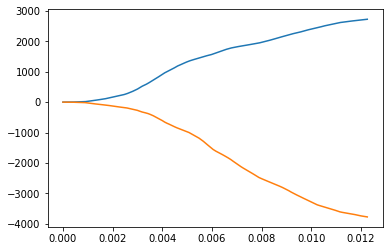

In [49]:
plt.plot(times, 2*kappa1*np.cumsum(sqq1[:-1])*dt)
plt.plot(times, -2*kappa1*np.cumsum(sqq0[:-1])*dt)

In [34]:
st01_sq = np.einsum('ti,ti->t',st01,st01)
st11_sq = np.einsum('ti,ti->t',st11,st11)

In [38]:
st01_st11 = np.einsum('ti,ti->t',st01,st11)

In [41]:
plt.plot(st01_sq + st11_sq- 2*st01_st11)

NameError: name 'st01_sq' is not defined

In [41]:
likSQ = np.einsum('ti,ti->t',st01 - st11, st01 - st11)

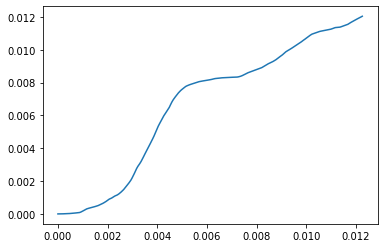

In [48]:
plt.plot(times, 2*kappa1*np.cumsum(likSQ[:-1])*dt)

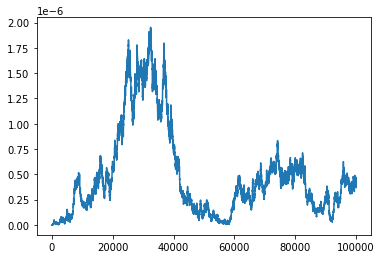

In [40]:
plt.plot(np.einsum('ti,ti->t',st01 - st11, st01 - st11))

In [7]:



n=1
ers = []
for itraj in tqdm(range(1,10000)):
    try:
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, mode=mode,dtt=dt ,total_time_in=total_time)
        for indb,b in enumerate(boundsB):
            if b>=0:
                stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b, times))
                stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b,times))

            for ind, time_index in enumerate(indis):
                deter_1 = log_lik_ratio[time_index] < b
                deter_0 = log_lik_ratio_swap[time_index] > b


                deter_data_h0_h1[itraj][indb][ind] = deter_1
                deter_data_h1_h0[itraj][indb][ind] = deter_0

                deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n
        l1= l1 + log_lik_ratio
        l0 = l0 +log_lik_ratio_swap
        n+=1
    except Exception:
        ers.append(itraj)
        pass
l0/=n#(Ntraj - len(ers))
l1/=n#(Ntraj - len(ers))


100%|██████████| 9999/9999 [08:05<00:00, 20.60it/s]


In [56]:
omega0

10000.0

In [57]:
dt

1.225987377010651e-07

In [59]:
np.log10(len(times))

6.0000004342942646

In [50]:
kappa1

1000000.0

In [43]:
l1[:-1]/times

<ipython-input-43-fe6667d4d27f>:1: RuntimeWarning: invalid value encountered in true_divide
  l1[:-1]/times


array([          nan,    0.        ,    0.        , ..., 2303.39788139,
       2303.40264754, 2303.40471361])

<ipython-input-42-bfbd02d9a641>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(l1[:-1]/times)


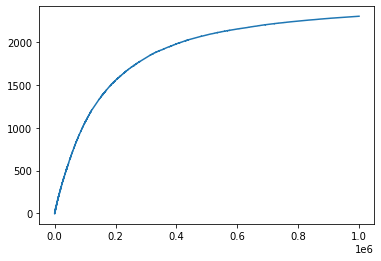

In [42]:
plt.plot(l1[:-1]/times)

In [24]:
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params_discrimination(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

total_time, dt = get_total_time_dt(params, total_time=T, ppp=ppp)

times = np.arange(0, total_time+ dt, dt)


indis = np.logspace(1,np.log10(len(times)-1), 50)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]


boundsB= np.arange(0,8,1.)


stop = {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}


er=[]
deter = {}
deter["h0/h1"] ={indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}

l0,l1 = np.zeros((2,len(times)+1))

deter_data_h0_h1 = np.zeros((Ntraj, len(boundsB), len(indis)))#{indb:{ind:[] for ind in indis} for indb in range(len(boundsB))}#["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}
deter_data_h1_h0 = np.zeros((Ntraj, len(boundsB), len(indis)))##{indb:{ind:[] for ind in indis} for indb in range(len(boundsB))}#["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}



n=1
ers = []
for itraj in tqdm(range(1,10000)):
    try:
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, mode=mode,dtt=dt ,total_time_in=total_time)
        for indb,b in enumerate(boundsB):
            if b>=0:
                stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b, times))
                stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b,times))

            for ind, time_index in enumerate(indis):
                deter_1 = log_lik_ratio[time_index] < b
                deter_0 = log_lik_ratio_swap[time_index] > b


                deter_data_h0_h1[itraj][indb][ind] = deter_1
                deter_data_h1_h0[itraj][indb][ind] = deter_0

                deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n
        l1= l1 + log_lik_ratio
        l0 = l0 +log_lik_ratio_swap
        n+=1
    except Exception:
        ers.append(itraj)
        pass
l0/=n#(Ntraj - len(ers))
l1/=n#(Ntraj - len(ers))


  4%|▍         | 434/9999 [00:29<10:45, 14.81it/s]


KeyboardInterrupt: 

In [48]:
times

array([0.00000000e+00, 1.22598738e-07, 2.45197475e-07, ...,
       1.22598493e-01, 1.22598615e-01, 1.22598738e-01])

In [46]:
l1[:-a1]/times[-1]

array([   0.        ,    0.        ,    0.        , ..., 2303.39327459,
       2303.40034414, 2303.40471361])

In [47]:
l0[:-1]/times[-1]

array([    0.        ,     0.        ,     0.        , ...,
       -2285.90270349, -2285.90254365, -2285.90796335])

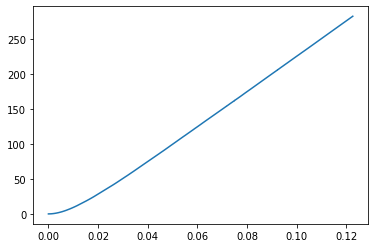

In [45]:
plt.plot(times,l1[:-1])

In [10]:
bpos = boundsB[boundsB >=0]
bneg = boundsB[boundsB <0]

stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())

for k,val in enumerate(values1):
    if len(val)>2:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))
        
for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


In [11]:
                
cons1, cons0 = [], []
anals1, anals0 = [], []
timbin0, timbin1 = [], []
for indb, b in enumerate(boundsB[int(len(boundsB)/2):]):
    counts1, bins1 = np.histogram(stops1[indb], 50, normed=True)
    counts0, bins0 = np.histogram(stops0[indb], 50, normed=True)
    
    timms1 = np.linspace(0,np.max(bins1), 100)
    timms0 = np.linspace(0,np.max(bins0), 100)
    
    timbins1 = .5*(bins1[1:] + bins1[:-1])
    timbins0 = .5*(bins0[1:] + bins0[:-1])
    
    cons1.append(counts1)
    cons0.append(counts0)
    
    timbin1.append(timbins1)
    timbin0.append(timbins0)
    
    gp1 =[prob(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)[0] for t in timms1]
    anals1.append(gp1)
    
    gp0 = [prob(t, b, kappa1, kappa0, eta1 , eta0, n1, n0, gamma1, gamma0)[0] for t in timms0]
    anals0.append(gp0)
    

<ipython-input-11-dd155c07152b>:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts1, bins1 = np.histogram(stops1[indb], 50, normed=True)
/home/giq/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:921: RuntimeWarning: invalid value encountered in true_divide
  return n/(n*db).sum(), bin_edges
<ipython-input-11-dd155c07152b>:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  cou

In [20]:
n

7246

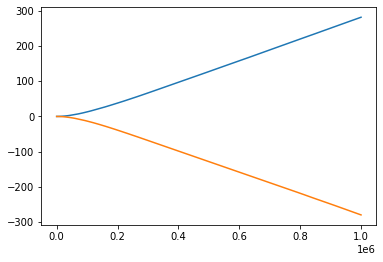

In [12]:
plt.plot(l1)
plt.plot(l0)

In [21]:

alphas = list(deter["h0/h1"].values())
betas = list(deter["h1/h0"].values())

alphas = np.stack(alphas)
betas = np.stack(betas)

bpos = boundsB[boundsB>=0]
bneg = boundsB[boundsB<0]

avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
avg_err_beta = lambda o :(1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))

errs = np.array([avg_err_alpha(b) for b in boundsB]) #
tot_err = 0.5*(alphas+betas)#0.5*(alphas + betas)
times_to_errs = [timind[np.argmin(np.abs(tot_err[indb,:] - errs[indb]))] for indb in range(len(bpos))]



stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())
for k,val in enumerate(values1):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))
        
for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


avg_times1 = np.array([np.mean(k) for k in stops1])
avg_times0 = np.array([np.mean(k) for k in stops0])

std_times1 = np.array([np.std(k) for k in stops1])
std_times0 = np.array([np.std(k) for k in stops0])
avg_times = 0.5*(avg_times0 + avg_times1)

std_times = np.sqrt(std_times1**2   + std_times0**2)#0.5*(np.array(avg_times0) + np.array(avg_times1) )
stoch = avg_times
stoch_std = std_times


avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]

<ipython-input-21-7160984af770>:10: RuntimeWarning: invalid value encountered in double_scalars
  avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
/home/giq/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/giq/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/giq/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/giq/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/giq/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid valu

In [22]:
avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
b_to_ep = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))

errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]

<ipython-input-22-b712e0ad23ba>:1: RuntimeWarning: invalid value encountered in double_scalars
  avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))


In [23]:
bb = np.linspace(0,1000,1000)
stop_avg_1, stop_avg_0 = [], []
for indb,b in enumerate(bb):
    if b>=0:
        stop_avg_1.append(get_stop_time(l1, b, times))
        stop_avg_0.append(get_stop_time(l0, b,times))

In [24]:
bb = np.linspace(0,1000,100)
stop_avg_1, stop_avg_0 = [], []
for indb,b in enumerate(boundsB):
    if b>=0:
        stop_avg_1.append(get_stop_time(l1, b, times))
        stop_avg_0.append(get_stop_time(l0, b,times))

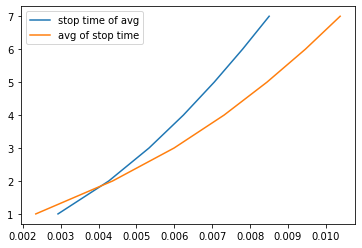

In [25]:
plt.plot(stop_avg_1, boundsB[boundsB>=0], label="stop time of avg")
plt.plot(stoch, boundsB[boundsB>=0], label="avg of stop time")
plt.legend()

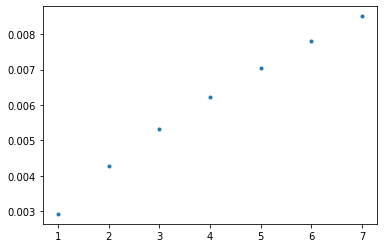

In [19]:
plt.plot(boundsB[boundsB>=0], stop_avg_1,'.')

In [27]:
ll1={}
ll0={}
for k in range(1,5):
    ll1[k], ll0[k] = load_liks(itraj=k, mode="frequencies", dtt=dt, total_time_in=total_time)
    

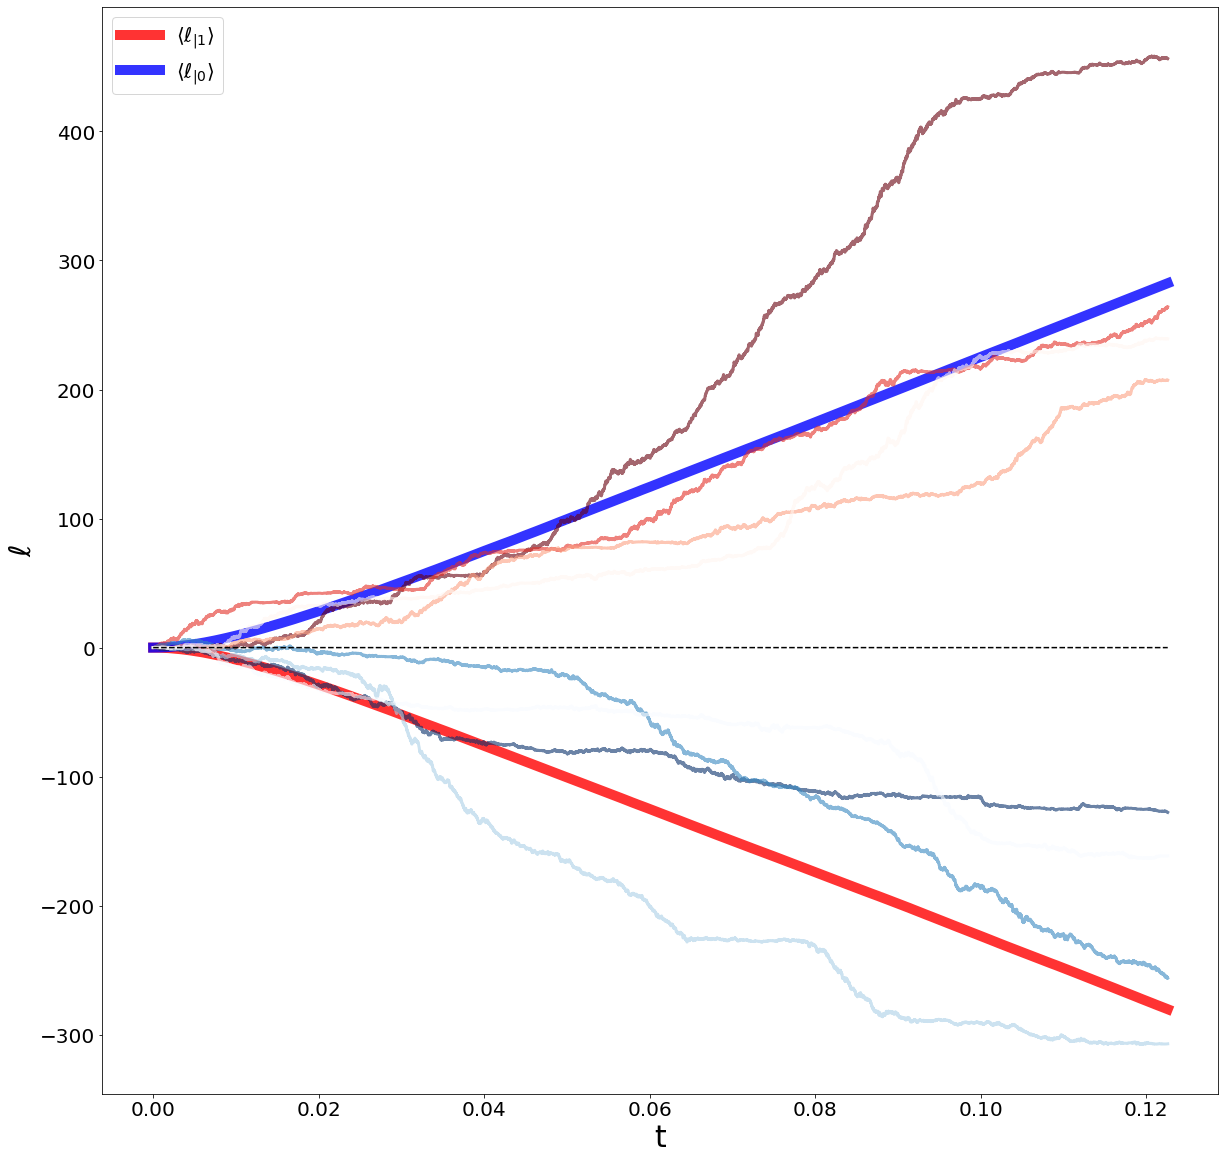

In [28]:
colors1 = plt.get_cmap("Reds")
colors0 = plt.get_cmap("Blues")
Ntraj = 4
Ltraj=3
LS=30
c1 = colors1(np.linspace(0,1,Ntraj))[::-1]
c0 = colors0(np.linspace(0,1,Ntraj))[::-1]

jump = 100
plt.figure(figsize=(20,20))
ax=plt.subplot(111)
ax.plot(times[::jump],l0[:-1][::jump], color="red", alpha=0.8, linewidth=10, label=r'$\langle \ell_{|1} \rangle$')
ax.plot(times[::jump],l1[:-1][::jump], color="blue", alpha=0.8, linewidth=10, label=r'$\langle \ell_{|0} \rangle$')
for ind,k in enumerate(range(1,5)):
    ax.plot(times[::jump],ll1[k][:-1][::jump], color=c1[ind], linewidth=Ltraj, alpha=0.6)
    ax.plot(times[::jump],ll0[k][:-1][::jump], color=c0[ind], linewidth=Ltraj, alpha=0.6)   
ax.plot(times[::jump], np.zeros(len(times))[::jump], '--', color="black")
ax.set_xlabel("t", size=LS)
ax.set_ylabel(r'$\ell$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(prop={"size":20})


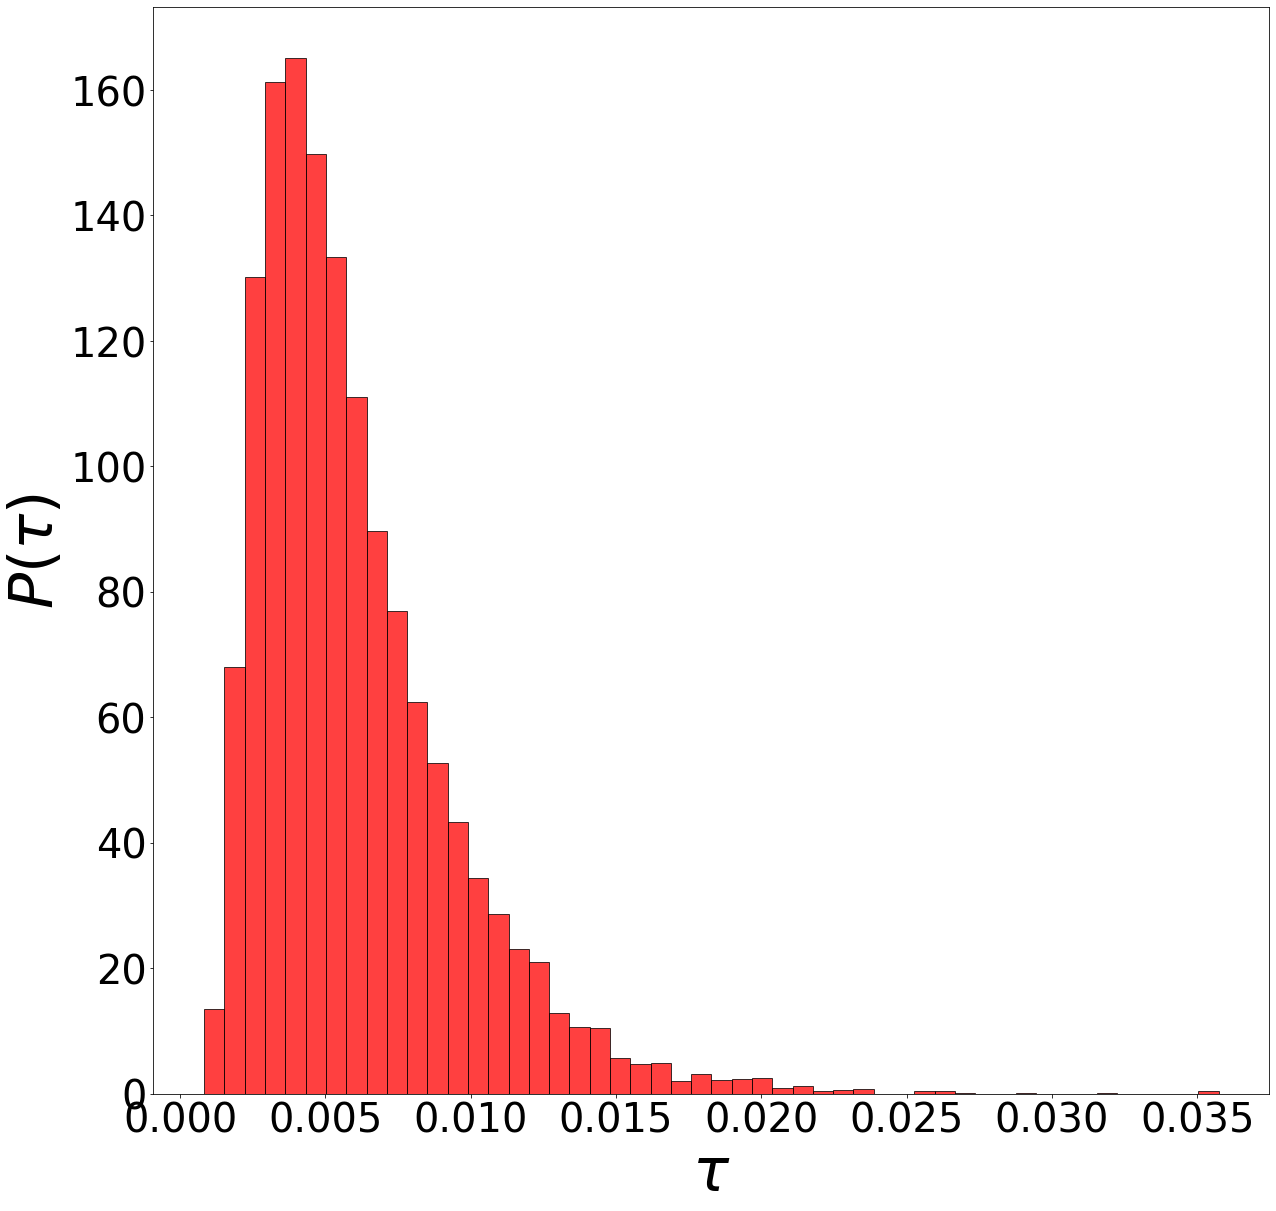

In [30]:
LS, TS = 60, 40
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
indb = -1
ax.bar(timbin1[indb], cons1[indb], width=timbin1[indb][1]-timbin1[indb][0], color="red", alpha=0.75, edgecolor="black",)#, label="simulations")
ax.set_xlabel(r'$\tau$',size=LS)
ax.set_ylabel(r'$P(\tau)$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)

In [125]:
len(stop["_1"])

999

In [31]:
avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]


<ipython-input-31-e1703a25a0cb>:1: RuntimeWarning: invalid value encountered in double_scalars
  avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))


In [40]:
times_alpha_to_errB/stoch

array([       nan, 3.1237001 , 2.67680517, 3.12257346, 3.23612502,
       3.54401411, 4.00211722, 4.61422614])

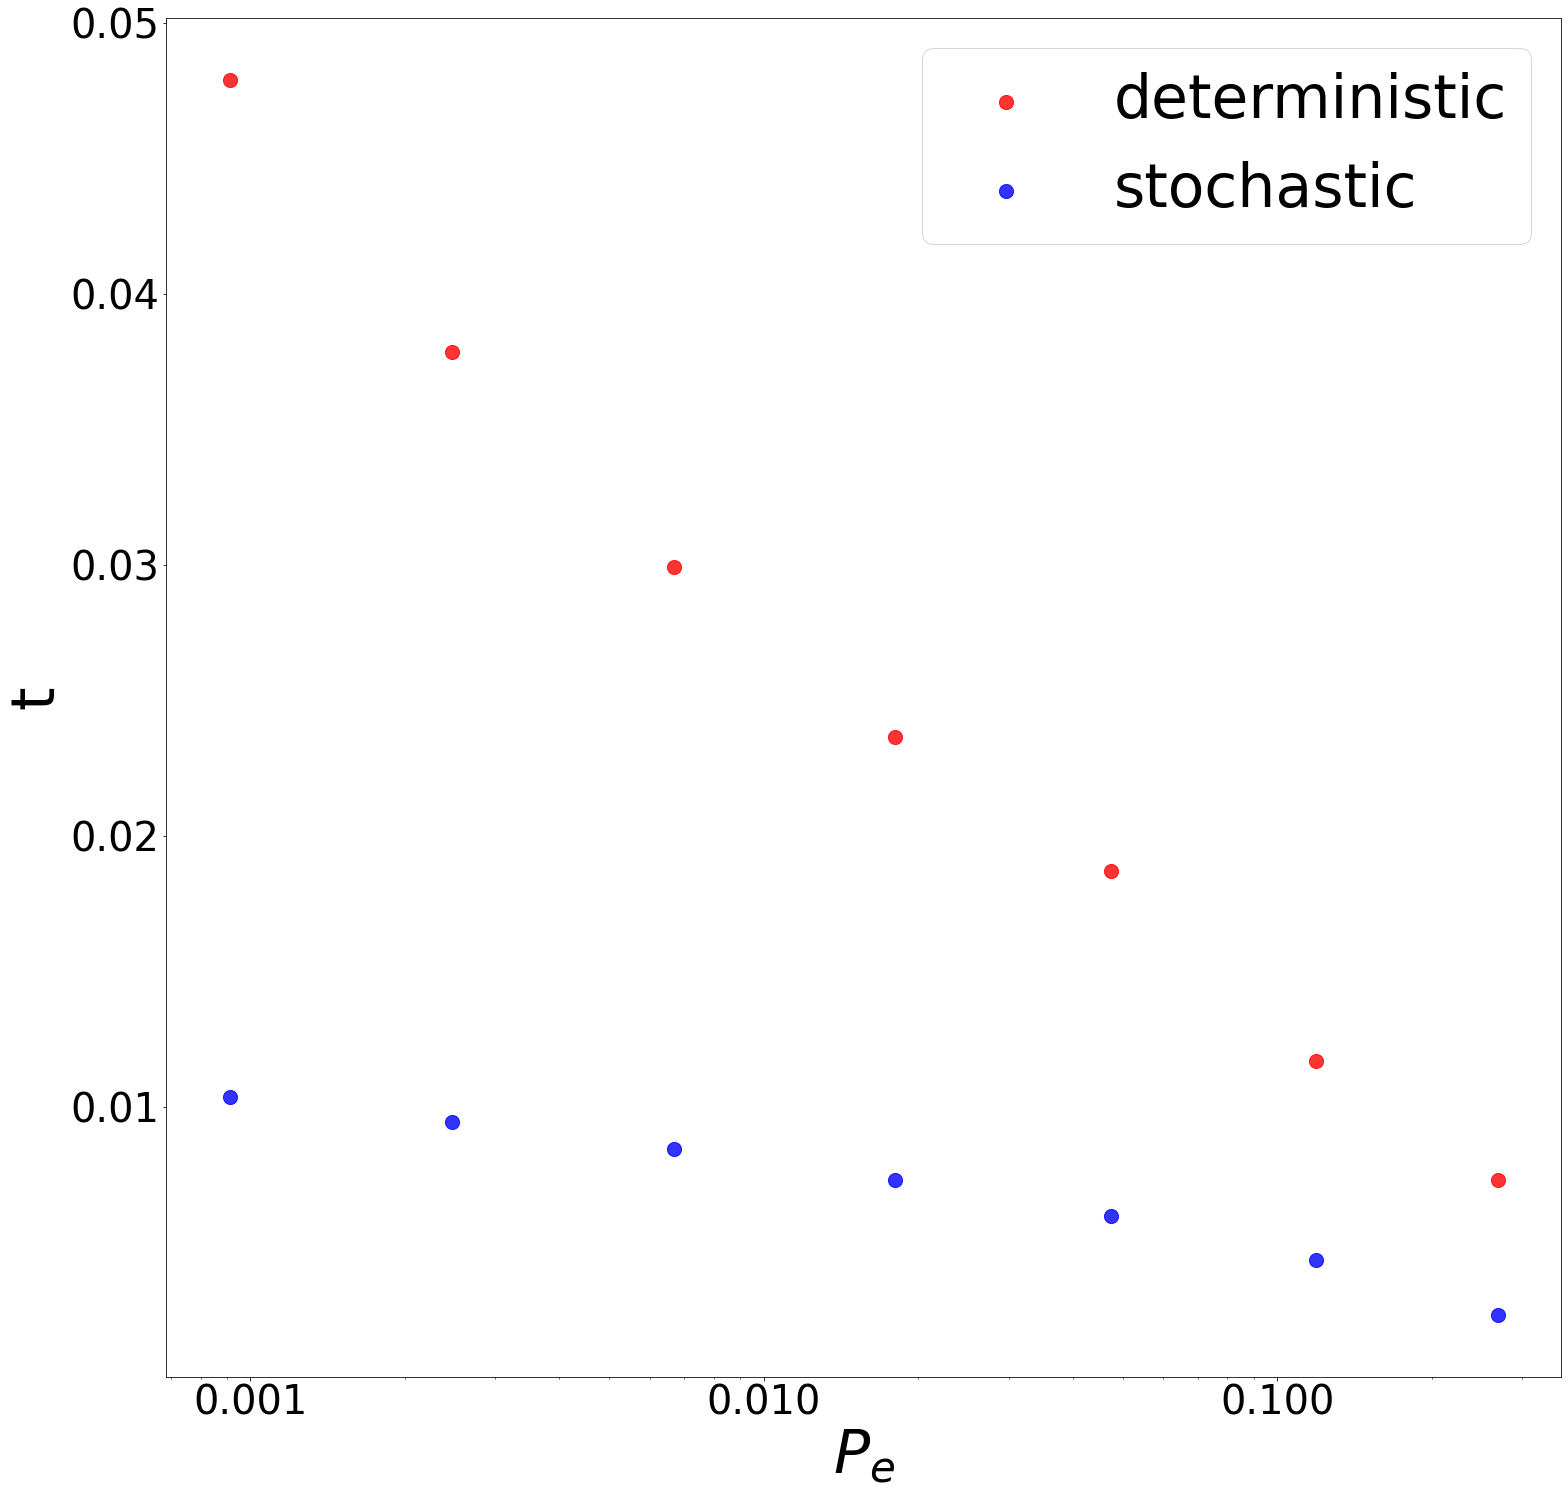

In [39]:

fig = plt.figure(figsize=(25,25))
ax = plt.subplot(111)
lw=10
ax.scatter(errs, times_alpha_to_errB,color="red", alpha=0.8,s=200, label="deterministic")
ax.scatter(errs, stoch ,color="blue",s=200,  alpha=0.8,label="stochastic")
#ax.fill_between(errs, stoch - stoch_std/2, stoch + stoch_std/2, alpha=0.5, color="blue")
ax.set_xscale("log")
#ax.set_xticks([np.round(k,2) for k in np.linspace(min(errs),max(errs),3)])
ax.set_xlabel(r'$P_e$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)
ax.set_ylabel("t", size=LS)
ax.legend(prop={"size":LS})
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
